Anticipation of moving stimuli by retina
Nature 1999 M. Berry

Modeling the response of a ganglion cell with gain control

Update History: creation Jan 1, 2018 by CKC



In [28]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

In [29]:
# use of two Gussian (one inverted) to approx the receptive field

def rf(x):
    rc = 1.0
    rs = 1.3
    kc = 1.3
    ks = 1.0
    a = x*x/2/rc/rc
    b = x*x/2/rs/rs
    return kc*np.exp(-a) - ks*np.exp(-b)

In [30]:
xnpts = 1000
xrange = 40.
x_offset = -xrange/2
x = np.zeros(xnpts)
for i in range(xnpts):
    x[i] = xrange*(i/xnpts) + x_offset

In [31]:
def xtoi(x,xnpts,xrange,x_offset): # convert position x into index i
    index = ((x-x_offset)/xrange)*xnpts
    return int(np.round(index))

In [6]:
xnpts = 1000
xrange = 40.
x_offset = -xrange/2
x = np.zeros(xnpts)
for i in range(xnpts):
    x[i] = xrange*(i/xnpts) + x_offset

#for i in range(xnpts):
#    print(x[i],' ',xtoi(x[i],xnpts,xrange,x_offset))

In [7]:
y = np.zeros(xnpts)
for i in range(xnpts):
    y[i] = rf(x[i])

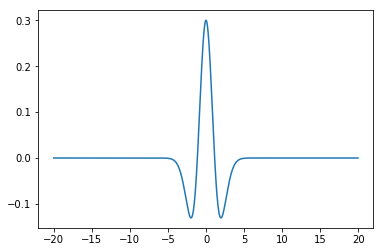

In [8]:
plt.plot(x,y)
plt.show()

In [9]:
def f_pulse(xnpts,xrange,x_offset,x_init,width,speed,x,t): #
    ix = xtoi(x,xnpts,xrange,x_offset) # x position in index of xnpts
    iwidth = (width/xrange)*xnpts
    #pulse position
    xnow   = x_init + speed*t # current position in terms of x
    inow = xtoi(xnow,xnpts,xrange,x_offset) # current position of the pulse in index of xnpts
    index1 = int(inow - iwidth/2)
    index2 = int(inow + iwidth/2)
    value = 0
    if ix > index1 and ix <index2:
        value = 1
    return value
    

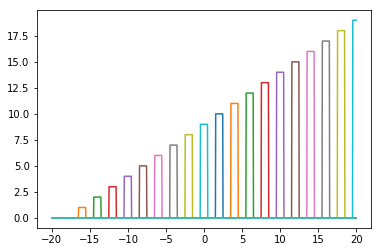

In [10]:
# a moving pulse

t = 20.0
speed = 1.0
x_init = x_offset
width = 1

y = np.zeros(xnpts)

for j in range(40):
    t = (j+1)*2
    for i in range(xnpts):
        y[i] =  j*f_pulse(xnpts,xrange,x_offset,x_init,width,speed,x[i],t)
    plt.plot(x,y)

plt.show()

In [11]:
# modeling biphasic response of ganglion cell
def k_t(a,b,c,t):
    return -a*np.sin(b*t)*np.exp(-c*t*t)

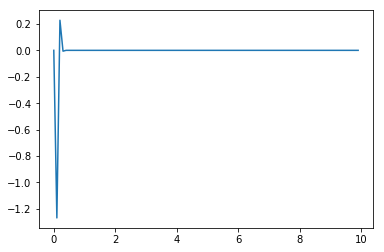

In [12]:
# check biphasic response

nstep = 100 # time step
t = 0.0
dt = 0.1
#Checking biphasic response

a = 20
b = 30
c = 80

f = np.zeros(nstep)
time = np.zeros(nstep)
for i in range(nstep):
    t = i*dt
    time[i] = t
    f[i] = k_t(a,b,c,t)

plt.plot(time,f)
plt.show()


In [13]:
k_t(a,b,c,0.1)

-1.2681861407550818

In [14]:
# time kernel for ganglion response

def t_kernel(delay):
    a = 20
    b = 30
    c = 80
    if delay > 0:
        return -a*np.sin(b*delay)*np.exp(-c*delay*delay)
    else:
        return 0.0

## Convolution

$ u(t) = g(v)\int_\infty^{-\infty}dx\int_{-\infty}^t S(x,t)k(x,t-t')dt'$


$v(t) = \int_{-\infty}^t dt' u(t')B e^{{-\frac{t-t'}{\tau}}}$

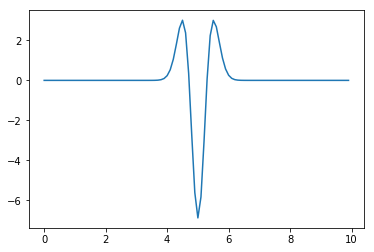

In [15]:
# convolution with a movig pulse

nstep = 100 # time step
t = 0.0
dt = 0.1
speed = 4.0
width = 1
    
cc = np.zeros(nstep)
tstep = np.zeros(nstep)
y = np.zeros(xnpts)
yrf = np.zeros(xnpts)

for j in range(xnpts):
    x[j] =  xrange*(j/xnpts) + x_offset
    yrf[j] = rf(x[j])

# main loop here

for i in range(nstep):
    t = i*dt
    tstep[i] = t
    ssum =0.0
    for k in range(nstep):
        tc = k*dt
        delay = t - tc
        val = t_kernel(delay)
        for j in range(xnpts):
            y[j]= f_pulse(xnpts,xrange,x_offset,x_init,width,speed,x[j],t)
            ssum = ssum + yrf[j]*y[j]*val
    cc[i] = ssum
plt.plot(tstep,cc)
plt.show()       

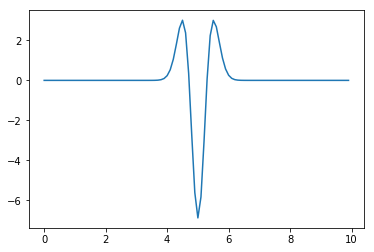

In [16]:
u = cc
plt.plot(tstep,u)
plt.show()

In [17]:
def feedback(u,n,nstep,tstep,B,tau):
    v = np.zeros(nstep)
    for i in range(nstep):
        t = tstep[i]
        sum = 0.0
        for j in range(i):
            tp = tstep[j]
            sum = sum + u[j]*np.exp(-(t-tp)/tau)*B
        v[i] = sum
    return v
    

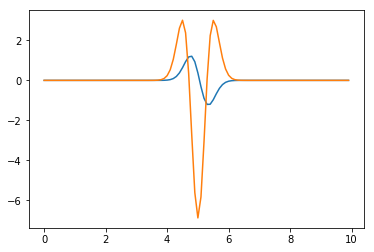

In [18]:
tau= 100
B = 0.1
n = 1
v = feedback(u,n,nstep,tstep,B,tau)
plt.plot(tstep,v)
plt.plot(tstep,u)
plt.show()

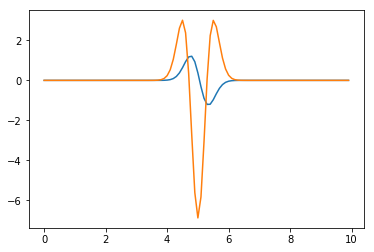

In [19]:
# applyng low pass filter
v = np.zeros(nstep)
tau = 100
B = 0.1
for i in range(nstep):
    t = tstep[i]
    sum = 0.0
    for j in range(i):
        tp = tstep[j]
        sum = sum + u[j]*np.exp(-(t-tp)/tau)*B
    v[i] = sum

plt.plot(tstep,v)
plt.plot(tstep,u)
plt.show()

In [20]:
# gain control
def gain(vv):
    val = 1
    if vv>0:
        val = 1/(1+vv**4)
    return val
    

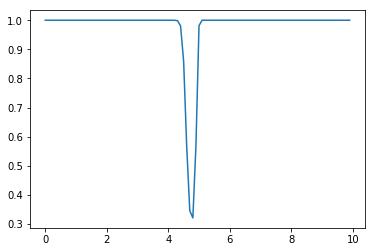

In [21]:
g = np.zeros(nstep)
for i in range(nstep):
    g[i] = gain(v[i])
plt.plot(tstep,g)
plt.show()

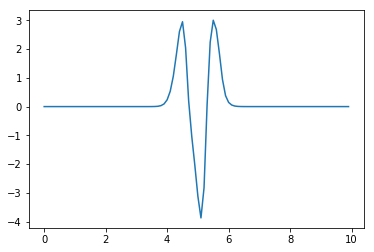

In [22]:
# convolution with gain control
nstep = 100 # time step
t = 0.0
dt = 0.1
speed = 4.0
width = 1
    
u = np.zeros(nstep)
v = np.zeros(nstep)
tstep = np.zeros(nstep)
y = np.zeros(xnpts)
yrf = np.zeros(xnpts)

for j in range(xnpts):
    x[j] =  xrange*(j/xnpts) + x_offset
    yrf[j] = rf(x[j])

# main loop here
g = np.zeros(nstep)
g[0] = 1.0

for i in range(nstep):# i is the index of time step
    t = i*dt
    tstep[i] = t
    ssum =0.0
    for k in range(nstep):
        tc = k*dt
        delay = t - tc
        val = t_kernel(delay)
        for j in range(xnpts):
            y[j]= f_pulse(xnpts,xrange,x_offset,x_init,width,speed,x[j],t)
            ssum = ssum + yrf[j]*y[j]*val
    u[i] = ssum*g[i]
    tau= 100
    B = 0.1
    t = tstep[i]
    ssum = 0.0
    for j in range(i):
        tp = tstep[j]
        ssum = ssum + u[j]*np.exp(-(t-tp)/tau)*B
    v[i] = ssum
    if i+1 < nstep-1:
        g[i+1] = gain(v[i]) # use v[i] to obtain g[i+1]; not equal time!!!
    
plt.plot(tstep,u)
plt.show()

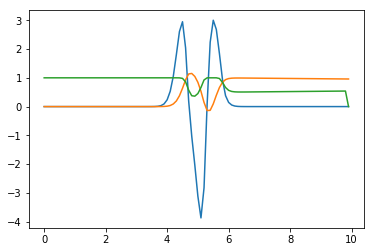

In [23]:
plt.plot(tstep,u)
plt.plot(tstep,v)
plt.plot(tstep,g)
plt.show()

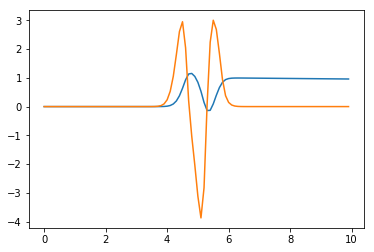

In [24]:
tau= 100
B = 0.1
n = 1
v = feedback(u,n,nstep,tstep,B,tau)
plt.plot(tstep,v)
plt.plot(tstep,u)
plt.show()

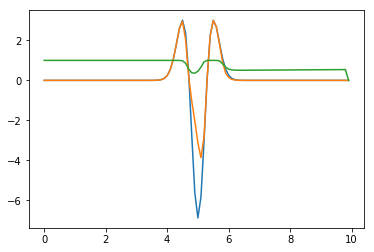

In [25]:
plt.plot(tstep,cc) # without gain control
plt.plot(tstep,u) # with gain control
plt.plot(tstep,g) # gain function
plt.show() 

In [26]:
def F(x,theta):
    if x < theta:
        return 0
    else:
        return x

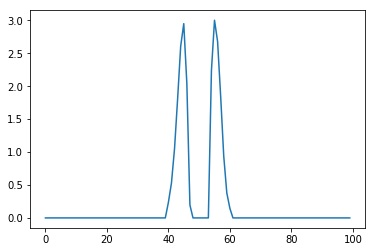

In [27]:
theta = 0.1
length = 100
result = np.zeros(length)
for i in range(length):
    result[i] = F(u[i],theta)
plt.plot(result)
plt.show()